# Pathway Activity in Human PBMC Single Cells

Single-cell RNA-seq provides unprecedented insights into variations in cell types between conditions, tissue types, species and individuals. Differential gene expression analysis of the single-cell data is almost always followed by *gene set enrichment analysis*, where the aim is to identify gene programs, such as biological processes, gene ontologies or regulatory pathways that are over-represented in an experimental condition compared to control or other conditions, on the basis of differentially expressed (DE) genes.

### Pathway activity tests

Gene set tests test whether a pathway is enriched, in other words over-represented, in one condition compared to others, say, in healthy donors compared to severe COVID-19 patients. An alternative approach is to simply score the activity of a pathway or gene signature, in absolute sense, in individual cells, rather than testing for a differential activity between conditions. Some of the widely used tools for inference of gene set activity in general (including pathway activity) in individual cells include *VISION* {cite}`detomaso2019functional`, *AUCell* <cite>`aibar2017scenic`</cite>, pathway overdispersion analysis using *Pagoda2* <cite>`fan2016characterizing, lake2018integrative`</cite> and simple combined z-score <cite>`lee2008inferring`</cite>. 

*DoRothEA* <cite>`garcia2019benchmark`</cite> and *PROGENy* <cite>`schubert2018perturbation`</cite> are among functional analysis tools developed to infer transcription factor (TF) - target activities originally in Bulk RNA data. Holland et al. <cite>`holland2020robustness`</cite> found that Bulk RNA-seq methods *DoRothEA* and *PROGENy* have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single cell data. Holland et al. also concluded that pathway and TF activity inference is more sensitive to the choice of gene sets rather than the statistical methods. This observation though can be specific to functional enrichment analyses and be explained by the fact that TF-target relations are context-specific; that is TF-target associations in one cell type may actually differ from another cell type or tissue.  

In contrast to Holand et al., Zhang et al. <cite>`zhang2020benchmarking`</cite> found that single-cell-based tools, specifically Pagoda2, outperform bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that pathway and gene set activity inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

We first download the 68K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes.

In [1]:
%reload_ext autoreload
%autoreload 2
from __future__ import annotations
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so
from tqdm.notebook import tqdm
import session_info
import os
import warnings
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import scanpy.external as sce
from scipy.optimize import linear_sum_assignment
from metrics import *
import scprep
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import magic
from activity import *


#!pip install ipywidgets --upgrade
os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.logging.print_versions()
#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
activity            NA
asttokens           NA
cffi                1.17.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
decoupler           1.7.0
deprecated          1.2.14
dill                0.3.8
exceptiongroup      1.2.1
executing           2.0.1
future              1.0.0
graphtools          1.5.3
h5py                3.11.0
igraph              0.11.6
importlib_resources NA
ipykernel           6.29.4
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
louvain             0.8.2
magic               3.0.0
matplotlib          3.9.0
matplotlib_inline   0.1.7
metrics             NA
mpl_toolkits        NA
natsort             8.4.0
nt                  NA
numba               0.6

The original dataset is from a single donor, from 10xgenomix. Fresh 68k PBMCs (Donor A).

- ~68,000 cells detected
- Sequenced on Illumina NextSeq 500 High Output with ~20,000 reads per cell
- 98bp read1 (transcript), 8bp I5 sample barcode, 14bp I7 GemCode barcode and 5bp read2 (UMI)
- Analysis run with --cells=24000

In [30]:
adata = sc.datasets.pbmc68k_reduced()
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [31]:
adata.obs['labels'] = adata.obs.bulk_labels.map({'CD14+ Monocyte':0, 'Dendritic':1, 'CD56+ NK':2, 'CD4+/CD25 T Reg':3, 'CD19+ B':4, 'CD8+ Cytotoxic T':5, 'CD4+/CD45RO+ Memory':6, 'CD8+/CD45RA+ Naive Cytotoxic':7, 'CD4+/CD45RA+/CD25- Naive T':8, 'CD34+':9})

In [32]:
sc.pp.filter_cells(adata, min_genes=2)
#sc.pl.highest_expr_genes(adata, n_top=20)

In [112]:
adata.raw.to_adata().X.toarray()[:5,:5]

array([[0.   , 0.   , 0.   , 1.591, 1.591],
       [1.55 , 0.   , 1.55 , 0.   , 0.   ],
       [0.   , 0.   , 1.374, 0.   , 0.   ],
       [0.   , 0.   , 1.711, 1.711, 0.   ],
       [0.   , 0.   , 0.   , 1.275, 0.   ]], dtype=float32)

It seems that preprocessing steps such as normalization and scaling were already performed on the dataset.

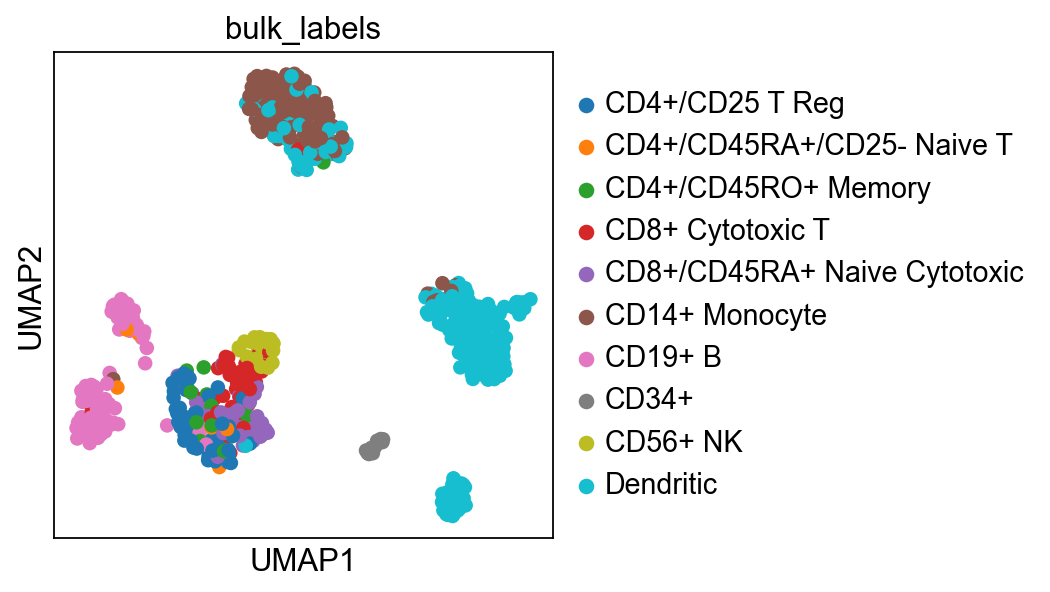

In [34]:
sc.pl.umap(adata, color=["bulk_labels"])

### Run Magic

In [113]:
sce.pp.magic(adata, name_list='all_genes')

In [14]:
adata.raw.to_adata().X[:5,:5]

array([[-0.326, -0.191, -0.728, -0.301,  3.386],
       [ 1.171, -0.191,  0.795, -1.2  , -0.174],
       [-0.326, -0.191,  0.483, -1.2  , -0.174],
       [-0.326, -0.191,  1.134, -0.157, -0.174],
       [-0.326, -0.191, -0.728, -0.607, -0.174]], dtype=float32)

## GSEA

#### Retrieving gene sets
Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [114]:
#Downloading reactome pathways.
from pathlib import Path

if not Path("./data/c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O './data/c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("./data/c2.cp.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

In [115]:
#Prepare the result matrix for GSEA scores.
num_cells = adata.shape[0]
num_gene_sets = len(reactome['geneset'].unique())
gsea_results_matrix = np.zeros((num_cells, num_gene_sets))

#Loop through each cell to run GSEA.
for cell_index in tqdm(range(num_cells)):
    #Get normalized expression values for the specific cell.
    cell_expr = adata.X[cell_index]
    
    #Create a DataFrame to hold DE scores.
    de_scores = pd.DataFrame(cell_expr, index=adata.var_names, columns=['scores'])
    
    #Run GSEA using decoupler.
    _, norm, _ = decoupler.run_gsea(
        de_scores.T,
        reactome,
        source="geneset",
        target="genesymbol"
    )
    
    #Store the normalized enrichment scores (NES) in the result matrix.
    gsea_results_matrix[cell_index, :] = norm.iloc[:, 0].values

#Save the result matrix for later use.
np.save('./data/gsea_results_matrix.npy', gsea_results_matrix)

100%|██████████| 700/700 [17:57<00:00,  1.54s/it]


### Cluster With KMeans

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


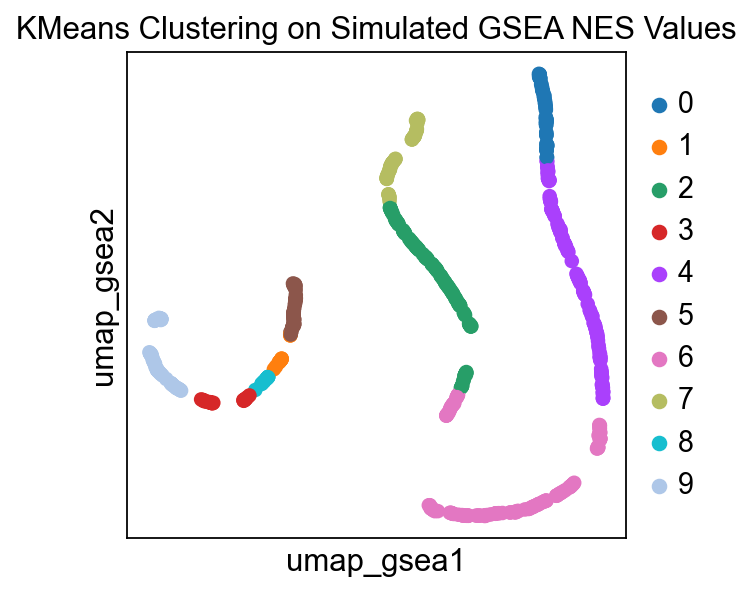

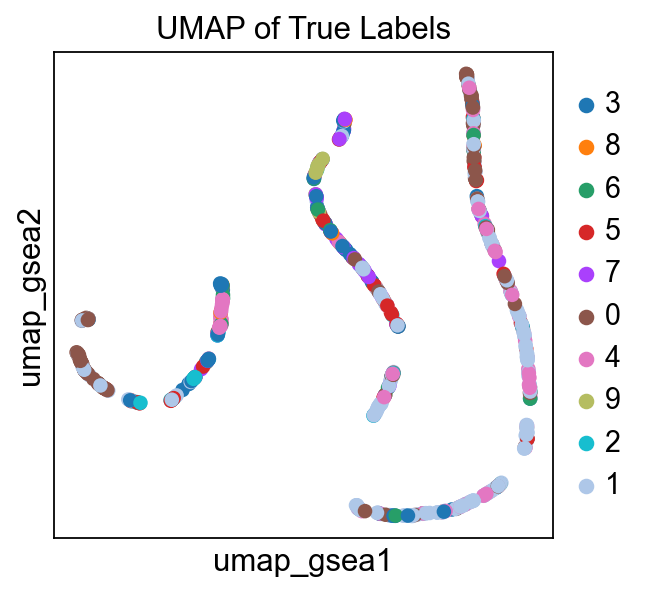

In [116]:
#Load the GSEA results matrix.
gsea_results_matrix = np.load('./data/gsea_results_matrix.npy')

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(gsea_results_matrix)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15, random_state=0)
umap_coords = umap_model.fit_transform(gsea_results_matrix)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_gsea'] = umap_coords
adata.obs['kmeans_gsea'] = pd.Categorical(kmeans.labels_)

#Plot the UMAP with KMeans clustering results using Scanpy.
#sc.pl.umap(adata, color=['kmeans1'], title='KMeans Clustering on Simulated GSEA NES Values', obsm_key='umap_gsea')
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels", obsm_key='umap_gsea')
sc.pl.embedding(adata, basis='umap_gsea', color=['kmeans_gsea'], title='KMeans Clustering on Simulated GSEA NES Values')
sc.pl.embedding(adata, basis='umap_gsea', color=["labels"], title="UMAP of True Labels")

In [117]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['X_umap']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: -0.23142781929155593
Calinski-Harabasz Index: 30.775410846925936
Special accuracy: 0.3357142857142857
completeness score: 0.2234387142166736
homogeneity_score: 0.24302232423389833
adjusted_mutual_info_score: 0.20818905868352225


I would like to run a pathway consensus analysis, i.e. for each method(gsea, progeny, aucell, pathsingle) run feature importance test. This test can be imlpemented differently for each method since they use different pathway sets, for example gsea uses genesets downloaded from reactome, while pathsingle is using pathways from its pathway database (built from KEGG). I would like to use shapley (shap) library for explainable ai, if possible, in order to extract the most important features of the different models, but if you prefer you can use simpler methods (for example forward selection of features using sklearn).

Please write the code for identifying the most important features for each method, and suggest a way for me to present the results so I can compare all results and check if there are comonalities/discrepancies between methods.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import shap

# Load your gene expression data.
gene_expression_data = pd.read_csv('gene_expression_data.csv')
labels = pd.read_csv('labels.csv')

# Placeholder functions for pathway activity scores.
def run_gsea(data):
    # Implement GSEA and return pathway activity scores.
    return np.random.rand(data.shape[0], 10)  # Example output.

def run_progeny(data):
    # Implement PROGENy and return pathway activity scores.
    return np.random.rand(data.shape[0], 10)  # Example output.

def run_aucell(data):
    # Implement AUCell and return pathway activity scores.
    return np.random.rand(data.shape[0], 10)  # Example output.

def run_pathsingle(data):
    # Implement PathSingle and return pathway activity scores.
    return np.random.rand(data.shape[0], 10)  # Example output.

# Get pathway activity scores.
gsea_scores = run_gsea(gene_expression_data)
progeny_scores = run_progeny(gene_expression_data)
aucell_scores = run_aucell(gene_expression_data)
pathsingle_scores = run_pathsingle(gene_expression_data)

In [ ]:
# Define a function to compute SHAP values.
def compute_shap_values(model, data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)
    return shap_values

# Train models and compute SHAP values for each method.
models = {}
shap_values = {}

for method, scores in zip(['gsea', 'progeny', 'aucell', 'pathsingle'], 
                          [gsea_scores, progeny_scores, aucell_scores, pathsingle_scores]):
    model = RandomForestClassifier()
    model.fit(scores, labels)
    models[method] = model
    shap_values[method] = compute_shap_values(model, scores)

# Example: Plot SHAP values for GSEA.
shap.summary_plot(shap_values['gsea'], gsea_scores, feature_names=[f'Pathway {i}' for i in range(gsea_scores.shape[1])])

In [ ]:
import matplotlib.pyplot as plt

# Plot SHAP summary for each method.
for method in ['gsea', 'progeny', 'aucell', 'pathsingle']:
    plt.figure()
    shap.summary_plot(shap_values[method], eval(f'{method}_scores'), feature_names=[f'Pathway {i}' for i in range(eval(f'{method}_scores').shape[1])])
    plt.title(f'SHAP Summary Plot for {method.upper()}')
    plt.show()

## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [118]:
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [119]:
decoupler.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running mlm on mat with 700 samples and 765 targets for 14 sources.


### Cluster With KMeans

Pathway activity matrix shape: (700, 14)


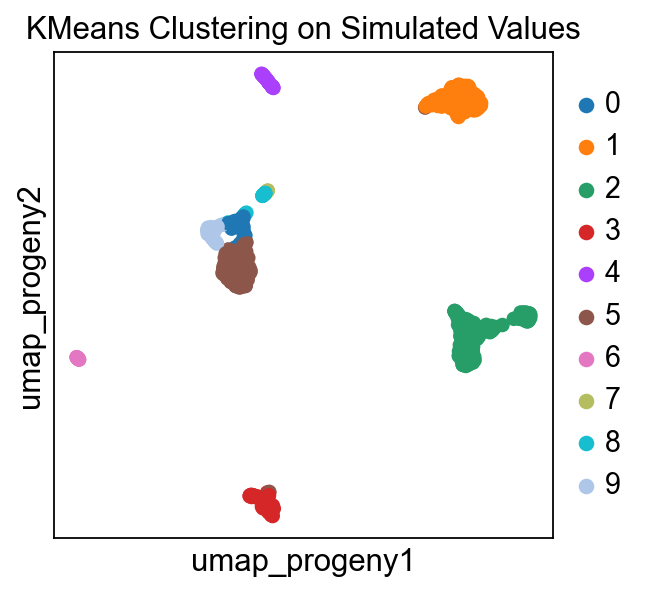

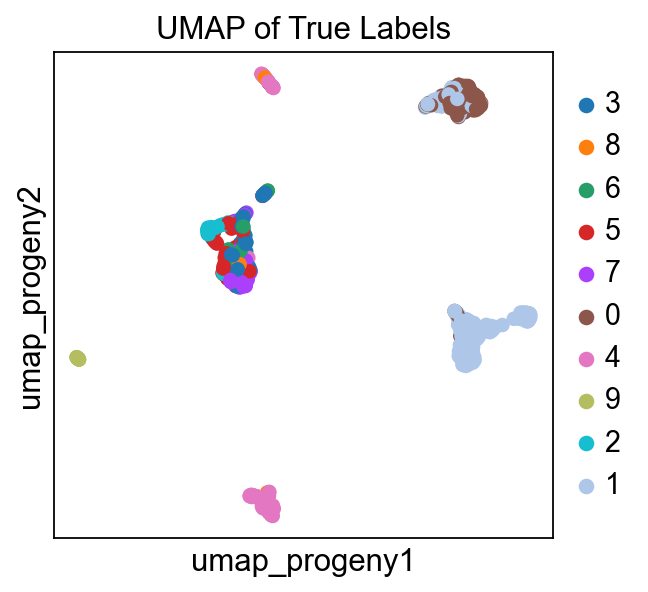

In [120]:
acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_progeny'] = umap_coords
adata.obs['kmeans_progeny'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
#sc.pl.umap(adata, color=["kmeans2"], title="KMeans Clustering on PROGENy Model Values.")
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels")
sc.pl.embedding(adata, basis='umap_progeny', color=['kmeans_progeny'], title='KMeans Clustering on Simulated Values')
sc.pl.embedding(adata, basis='umap_progeny', color=["labels"], title="UMAP of True Labels")

### Cluster Results

In [121]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.6874681115150452
Calinski-Harabasz Index: 1832.2643760682301
Special accuracy: 0.6728571428571428
completeness score: 0.6534441910112415
homogeneity_score: 0.6405513594602779
adjusted_mutual_info_score: 0.6354366349968071


## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [122]:
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
    verbose=True
)

Running aucell on mat with 700 samples and 765 targets for 266 sources.


100%|██████████| 700/700 [00:00<00:00, 836.30it/s] 


### Cluster With KMeans

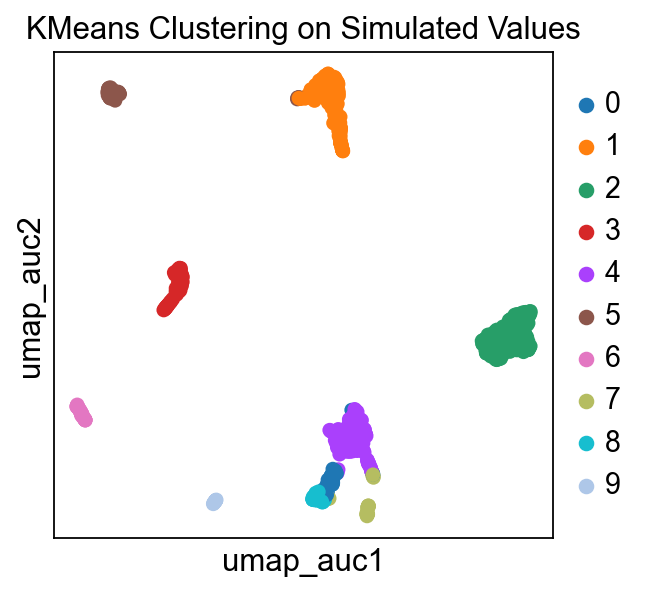

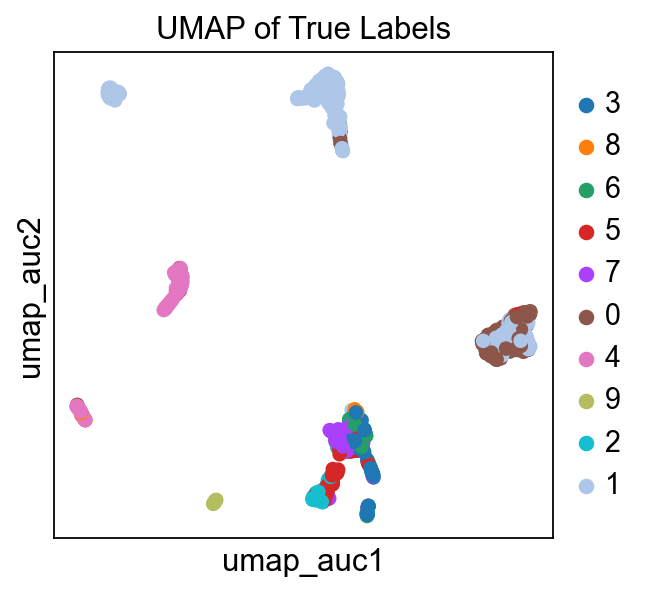

In [123]:
#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = adata.obsm["aucell_estimate"]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15)
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_auc'] = umap_coords
adata.obs['kmeans_auc'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
#sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on AUCELL Values.")
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels")
sc.pl.embedding(adata, basis='umap_auc', color=['kmeans_auc'], title='KMeans Clustering on Simulated Values')
sc.pl.embedding(adata, basis='umap_auc', color=["labels"], title="UMAP of True Labels")

### Cluster Results

In [124]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['aucell_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.5966818332672119
Calinski-Harabasz Index: 981.4662121141115
Special accuracy: 0.63
completeness score: 0.6321781210390296
homogeneity_score: 0.6556592320945923
adjusted_mutual_info_score: 0.631956028010743


## PathSingle

In [129]:
activity_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
#activity_df = scprep.normalize.library_size_normalize(activity_df)
#activity_df = scprep.transform.sqrt(activity_df)
magic_op = magic.MAGIC()
activity_df = magic_op.fit_transform(activity_df)

activity_df.to_csv('./data/activity_df.csv', index=True)

Calculating MAGIC...
  Running MAGIC on 700 cells and 765 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.30 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.41 seconds.
  Calculating imputation...
  Calculated imputation in 0.03 seconds.
Calculated MAGIC in 0.44 seconds.


### Run PathSingle

In [130]:
activity = sc.read('./data/activity_df.csv', delimiter=',', cache=False)
calc_activity(activity)

AnnData object with n_obs × n_vars = 700 × 765


100%|██████████| 140/140 [01:50<00:00,  1.27it/s]


### Cluster With KMeans

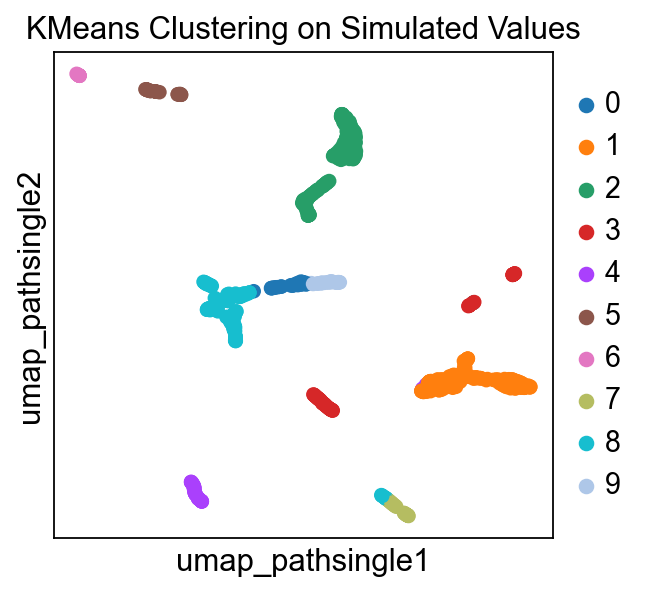

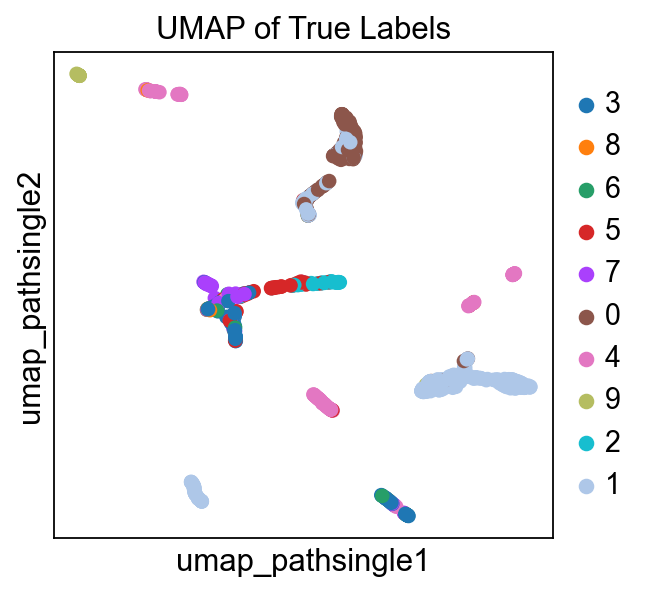

In [131]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer


output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

selector = VarianceThreshold(threshold=0.01)
output_activity = selector.fit_transform(output_activity)

#Scale the data.
scaler = MinMaxScaler()
output_activity = scaler.fit_transform(output_activity)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(output_activity)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(output_activity)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_pathsingle'] = umap_coords
adata.obs['kmeans_pathsingle'] = pd.Categorical(kmeans.labels_)
#cell_state = adata.obs['labels']
#cdata.obs['state'] = cell_state[emt_magic.index].values

#Plotting UMAP with KMeans clustering results using scanpy.
#sc.pl.umap(adata, color=["kmeans4"], title="KMeans Clustering on PathSingle Model Values.")
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels")
sc.pl.embedding(adata, basis='umap_pathsingle', color=['kmeans_pathsingle'], title='KMeans Clustering on Simulated Values')
sc.pl.embedding(adata, basis='umap_pathsingle', color=["labels"], title="UMAP of True Labels")

### Cluster Results

In [132]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = output_activity

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.7114650690472544
Calinski-Harabasz Index: 2504.5645227435352
Special accuracy: 0.6471428571428571
completeness score: 0.6371810345231945
homogeneity_score: 0.6592658287863037
adjusted_mutual_info_score: 0.636416226684575


In [134]:
adata.write("./data/adata_pbmc.h5ad")

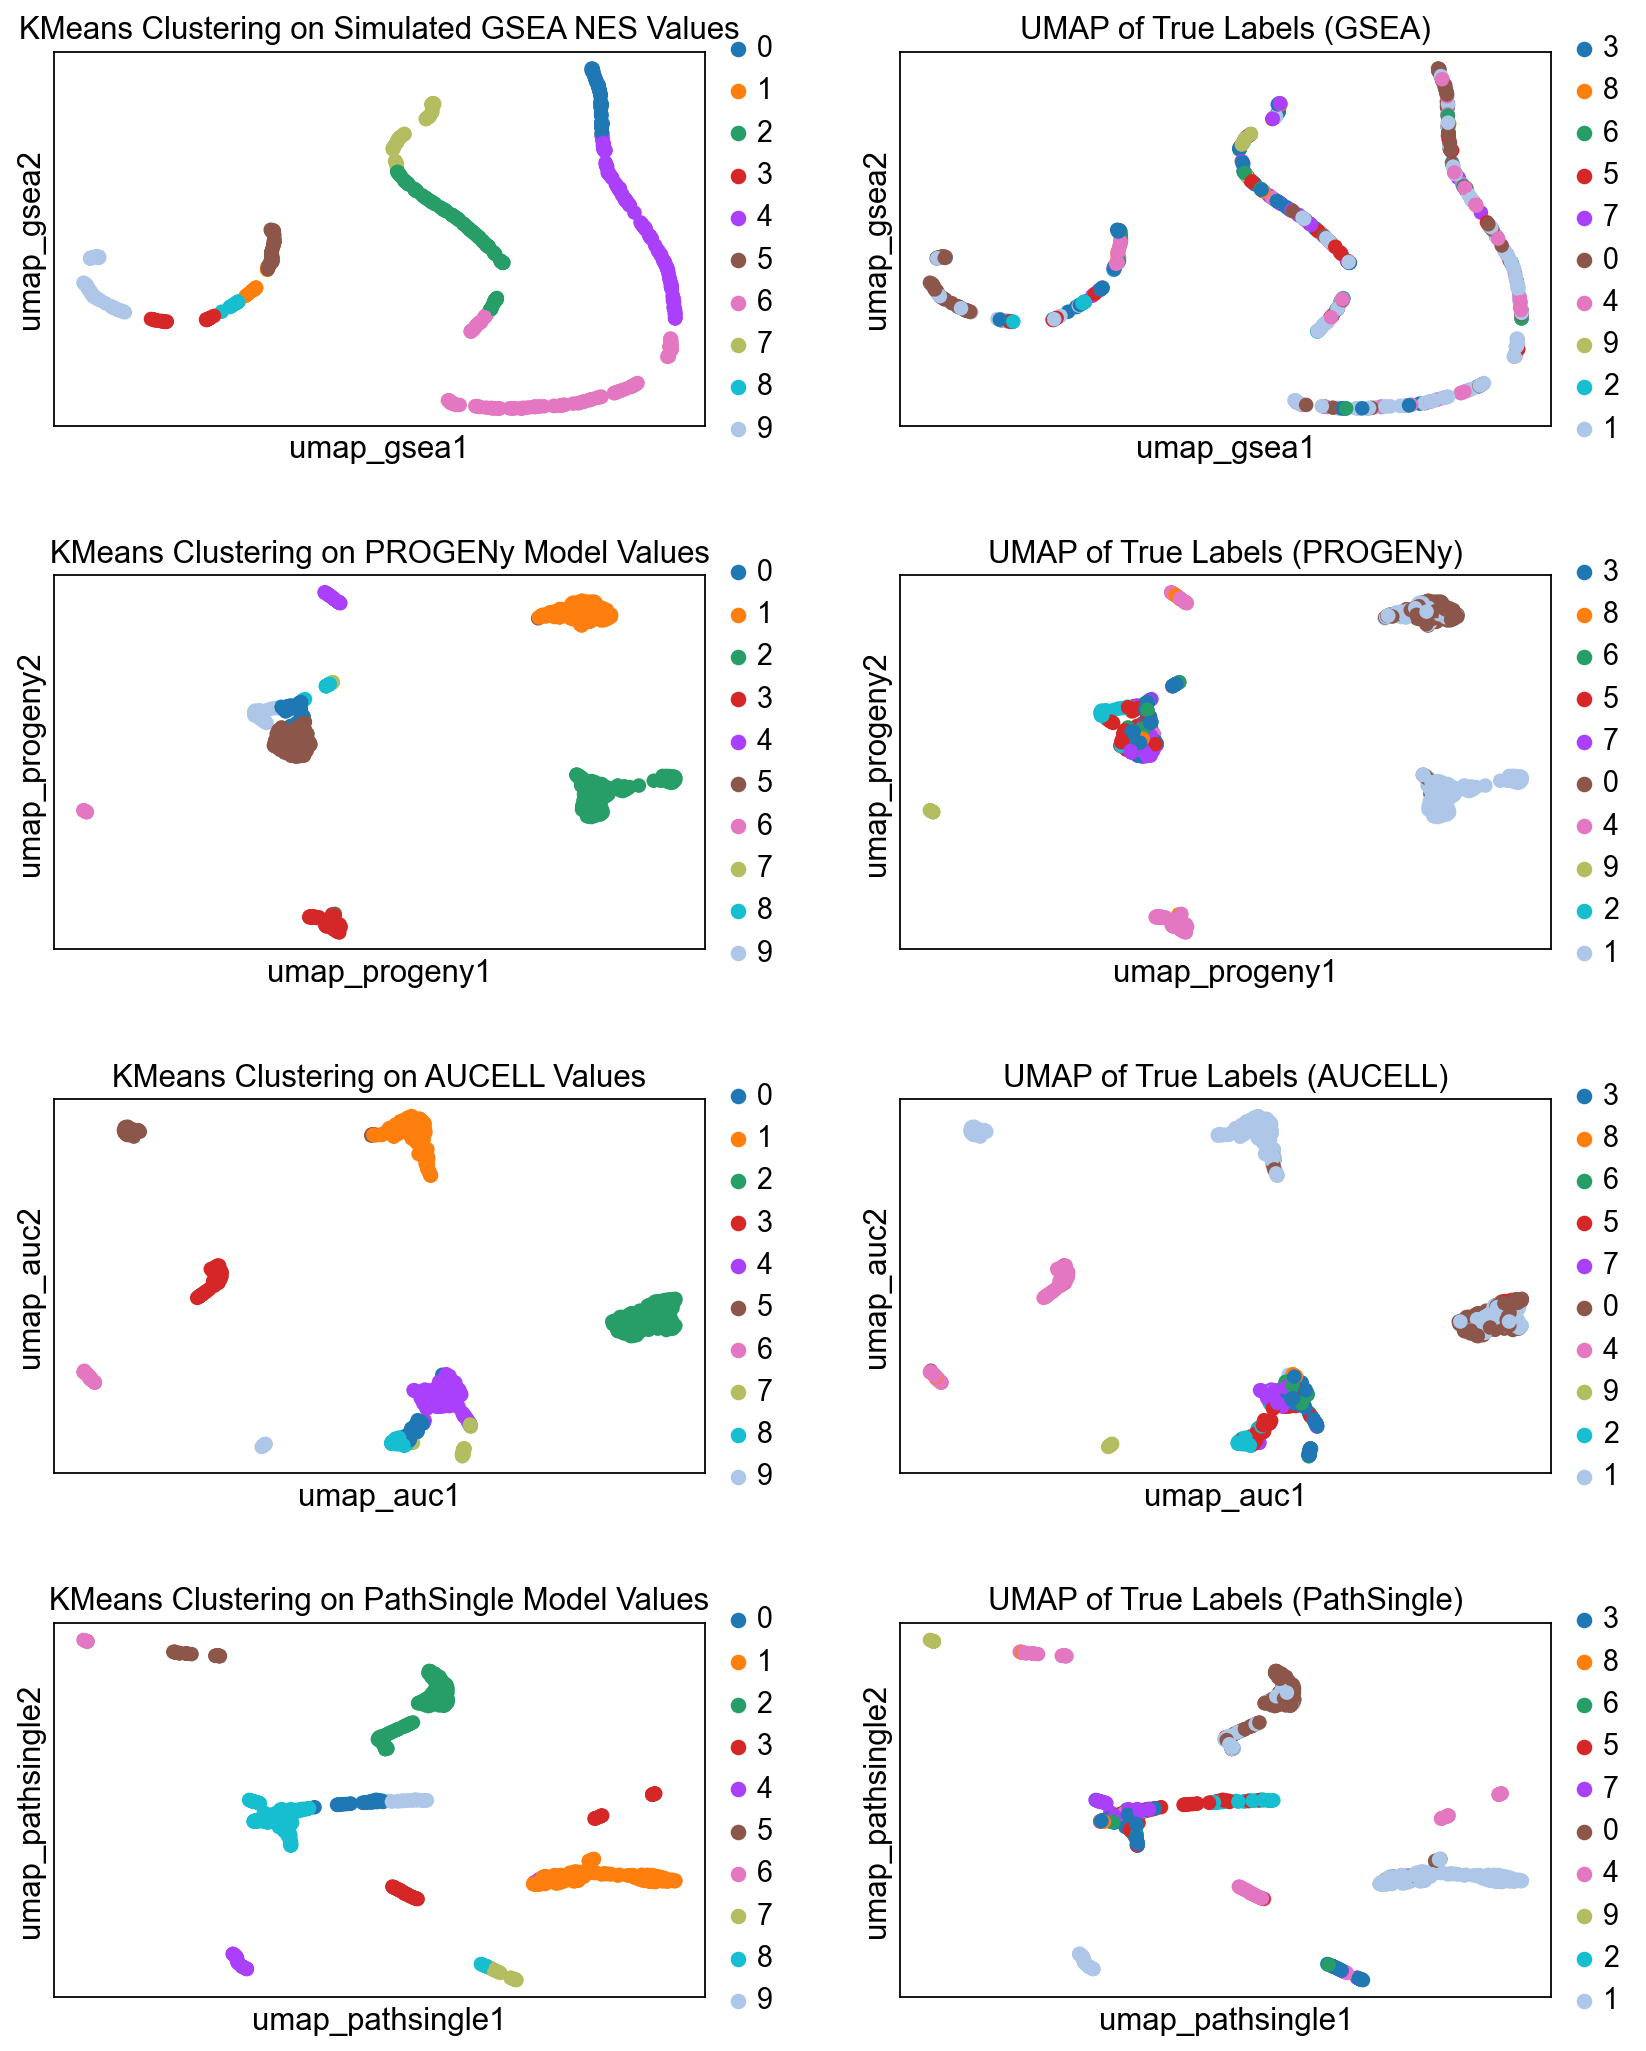

In [135]:
#adata = sc.read_h5ad("./data/adata_pbmc.h5ad")
# Define a figure with a 4x2 grid (4 rows, 2 columns).
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Adjust the spacing between plots.
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Define the plotting function for each subplot using sc.pl.embedding.
def plot_umap(ax, adata, umap_key, color, title):
    sc.pl.embedding(adata, basis=umap_key, color=color, title=title, ax=ax, show=False)
    ax.set_frame_on(True)  # Add a frame to each subplot.

# Plot each UMAP with its KMeans clustering and true labels side by side.

# Plot UMAP for GSEA.
plot_umap(axs[0, 0], adata, 'umap_gsea', color='kmeans_gsea', title='KMeans Clustering on Simulated GSEA NES Values')
plot_umap(axs[0, 1], adata, 'umap_gsea', color="labels", title="UMAP of True Labels (GSEA)")

# Plot UMAP for PROGENy.
plot_umap(axs[1, 0], adata, 'umap_progeny', color="kmeans_progeny", title="KMeans Clustering on PROGENy Model Values")
plot_umap(axs[1, 1], adata, 'umap_progeny', color="labels", title="UMAP of True Labels (PROGENy)")

# Plot UMAP for AUCELL.
plot_umap(axs[2, 0], adata, 'umap_auc', color="kmeans_auc", title="KMeans Clustering on AUCELL Values")
plot_umap(axs[2, 1], adata, 'umap_auc', color="labels", title="UMAP of True Labels (AUCELL)")

# Plot UMAP for PathSingle.
plot_umap(axs[3, 0], adata, 'umap_pathsingle', color="kmeans_pathsingle", title="KMeans Clustering on PathSingle Model Values")
plot_umap(axs[3, 1], adata, 'umap_pathsingle', color="labels", title="UMAP of True Labels (PathSingle)")

# Save the figure to a file.
plt.savefig("umap_clustering_layout.png", dpi=300, bbox_inches='tight')

# Show the figure.
plt.show()

## Session info

In [12]:
session_info.show()

### References

https://www.sc-best-practices.org/conditions/gsea_pathway.html

https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

https://en.wikipedia.org/wiki/Dunn_index

https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.

https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_04_clustering.html

https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc68k_reduced.html#norm

https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

https://www.10xgenomics.com/datasets/fresh-68-k-pbm-cs-donor-a-1-standard-1-1-0